<a href="https://colab.research.google.com/github/gnidetsanna/python_for_ML_tasks/blob/main/HW_2_8_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_Hnidets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1###
В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
!pip install opendatasets --upgrade --quiet
!pip install pyarrow --quiet

import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, r2_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu'
os.listdir(data_dir)
train_csv = data_dir + '/train.csv'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gnidetsanna
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 1.17MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [4]:
raw_df = pd.read_csv(train_csv, index_col=0)
updated_df = raw_df.drop(columns=['CustomerId', 'Surname'])

train_df, val_df = train_test_split(updated_df, test_size=0.20, random_state=42, stratify=updated_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(updated_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# # Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()


In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [31]:
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    accuracy = accuracy_score(targets, preds)

    preds_proba = model_pipeline.predict_proba(inputs)
    roc_auc_1 = roc_auc_score(targets, preds_proba[:, 1])

    print(f"Оцінка точності {name} dataset: {accuracy:.2f}")
    print(f"Area under ROC score on {name} dataset: {roc_auc_1:.2f}")
    f1 = f1_score(targets, preds, pos_label=1)
    print(f"F1 score = {f1}")
    RMSE = mean_squared_error(targets, preds, squared=False)
    print(f"RMSE = {RMSE}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

Оцінка точності Training dataset: 0.87
Area under ROC score on Training dataset: 0.88
F1 score = 0.6301303718010622
RMSE = 0.3573047252229764


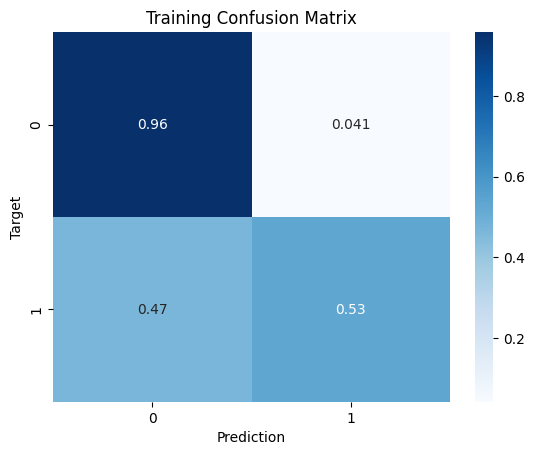

Оцінка точності Validation dataset: 0.87
Area under ROC score on Validation dataset: 0.88
F1 score = 0.638888888888889
RMSE = 0.36055512754639896


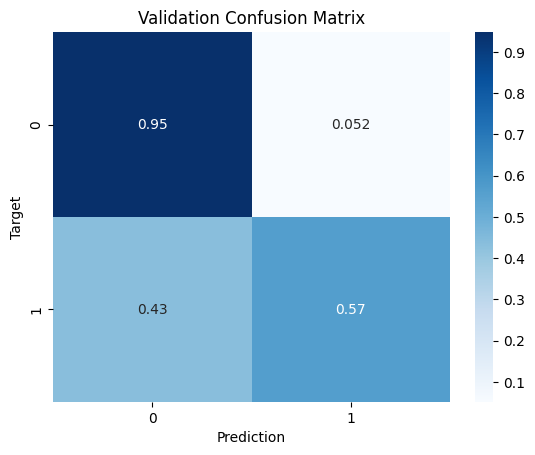

In [32]:
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

In [8]:
joblib.dump(model_pipeline, 'exit_bank_pipeline.joblib')

['exit_bank_pipeline.joblib']

In [21]:
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)

X_test = test_raw_df.drop(columns=['CustomerId', 'Surname'])  # Припускаємо, що тестові дані мають ті ж самі стовпці, крім 'Exited'
test_predictions = model_pipeline.predict_proba(X_test)[:,1]
new_df = pd.DataFrame({'id': X_test['id'], 'Exited': test_predictions})
sub_csv = data_dir + '/sample_submission.csv'
sub_csv = pd.read_csv(sub_csv)

for idx in new_df.index:
    if sub_csv.at[idx, 'id'] == new_df.at[idx, 'id']:
      sub_csv.at[idx, 'Exited'] = new_df.at[idx, 'Exited']
    else:
      continue
sub_csv.to_csv('sub.csv', index=False)

###Завдання 2###
 Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [33]:
import operator
from sklearn.preprocessing import PolynomialFeatures


numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

processor_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

processor_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Оцінка точності Training dataset: 0.89
Area under ROC score on Training dataset: 0.92
F1 score = 0.6925627664613927
RMSE = 0.32888701200665654


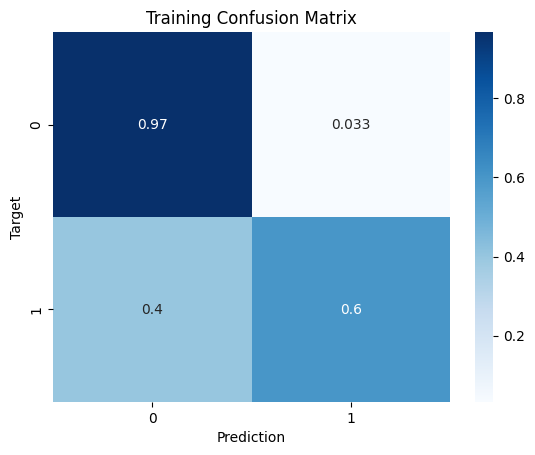

Оцінка точності Validation dataset: 0.89
Area under ROC score on Validation dataset: 0.92
F1 score = 0.6923783287419651
RMSE = 0.334165627596057


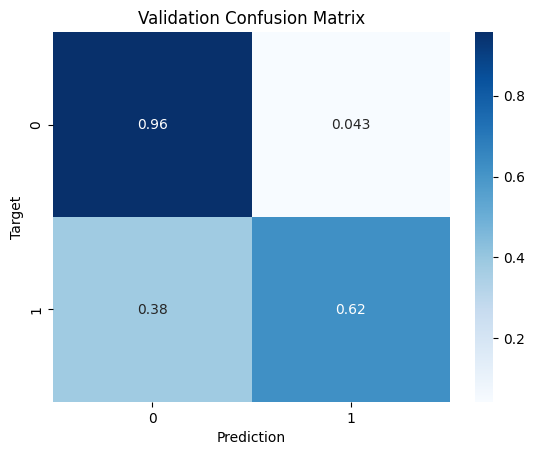

In [47]:
train_preds = predict_and_plot(processor_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(processor_pipeline, val_inputs, val_targets, 'Validation')

In [48]:
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)

X_test = test_raw_df.drop(columns=['CustomerId', 'Surname'])  # Припускаємо, що тестові дані мають ті ж самі стовпці, крім 'Exited'
test_predictions = processor_pipeline.predict_proba(X_test)[:,1]
new_df = pd.DataFrame({'id': X_test['id'], 'Exited': test_predictions})
sub_csv = data_dir + '/sample_submission.csv'
sub_csv = pd.read_csv(sub_csv)

for idx in new_df.index:
    if sub_csv.at[idx, 'id'] == new_df.at[idx, 'id']:
      sub_csv.at[idx, 'Exited'] = new_df.at[idx, 'Exited']
    else:
      continue
sub_csv.to_csv('sub_poly2.csv', index=False)

###Висновки 2###
Тренувальна точність не вища за валідаційну, не спостерігається ні overfitting, ні underfitting.
Генералізація висока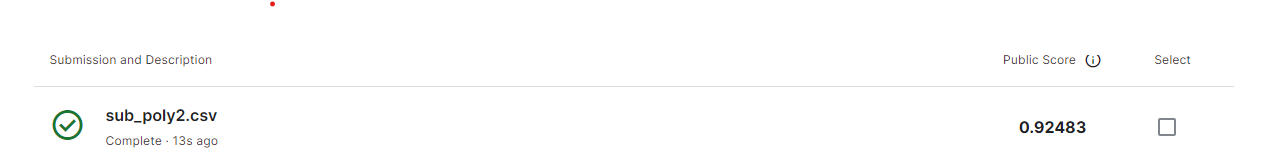

###Завдання 3###
Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [49]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

processor_4_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

processor_4_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False))]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Оцінка точності Training dataset: 0.90
Area under ROC score on Training dataset: 0.93
F1 score = 0.7329390354868062
RMSE = 0.31278320500521334


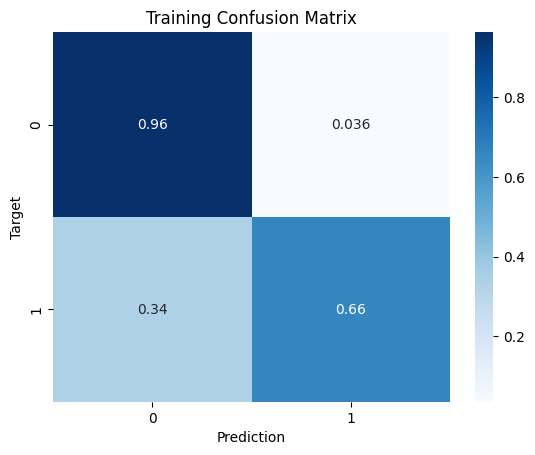

Оцінка точності Validation dataset: 0.90
Area under ROC score on Validation dataset: 0.93
F1 score = 0.7310098302055407
RMSE = 0.31675437381878935


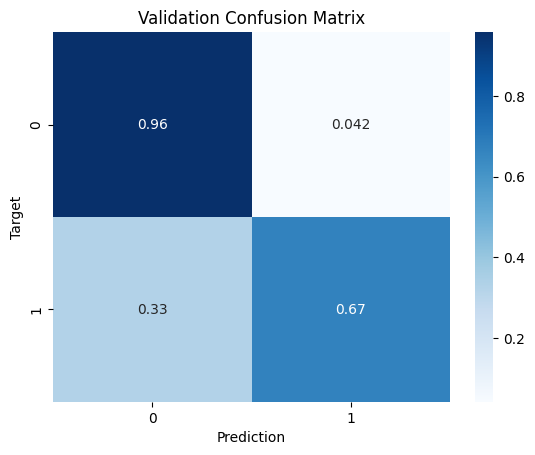

In [50]:
train_preds = predict_and_plot(processor_4_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(processor_4_pipeline, val_inputs, val_targets, 'Validation')

In [51]:
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)

X_test = test_raw_df.drop(columns=['CustomerId', 'Surname'])  # Припускаємо, що тестові дані мають ті ж самі стовпці, крім 'Exited'
test_predictions = processor_pipeline.predict_proba(X_test)[:,1]
new_df = pd.DataFrame({'id': X_test['id'], 'Exited': test_predictions})
sub_csv = data_dir + '/sample_submission.csv'
sub_csv = pd.read_csv(sub_csv)

for idx in new_df.index:
    if sub_csv.at[idx, 'id'] == new_df.at[idx, 'id']:
      sub_csv.at[idx, 'Exited'] = new_df.at[idx, 'Exited']
    else:
      continue
sub_csv.to_csv('sub_poly4.csv', index=False)

###Висновок 3###
Генералізація при ступені 4 не змінилась
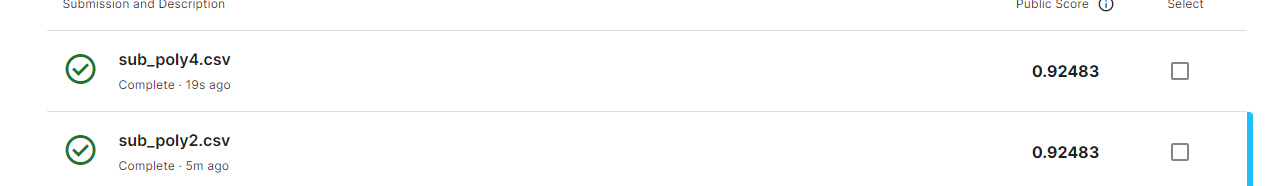

###Завдання 4###
 Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [65]:
reg_path_csv =  '/content/drive/MyDrive/Homeworks/regression_data.csv'
reg_df = pd.read_csv(reg_path_csv)

In [73]:
reg_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [80]:
reg_df.dtypes

feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
target       float64
dtype: object

In [72]:
train_reg, val_reg = train_test_split(reg_df, test_size=0.20, random_state=42)


# Створюємо трен. і вал. набори
input_cols = list(reg_df.columns)[1:-1]
target_col = 'target'
train_inputs, train_targets = train_reg[input_cols], train_reg[target_col]
val_inputs, val_targets = val_reg[input_cols], val_reg[target_col]

In [77]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

processor_5_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

processor_5_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False))]),
                                                  ['feature_2', 'feature_3',
                                                   'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

In [99]:
def train_poly_reg_and_plot(X_train, X_val, y_train, y_val):

  y_train_pred = processor_5_pipeline.predict(X_train)
  y_val_pred = processor_5_pipeline.predict(X_val)

  rmse_poly_train = mean_squared_error(y_train, y_train_pred, squared=False)

  rmse_poly_val = mean_squared_error(y_val, y_val_pred, squared=False)

  print(f"Train RMSE for Polynomial Regression (degree 5): {np.sqrt(rmse_poly_train):.3f}")
  print(f"Test RMSE for Polynomial Regression (degree 5): {np.sqrt(rmse_poly_val):.3f}")
  return y_train_pred

In [100]:
a = train_poly_reg_and_plot(train_inputs, val_inputs, train_targets, val_targets)

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 9.497


###Висновок 4###
Спостерігаємо високий рівень overfitting.
Модель погана, погано генералізує як бачимо з результату на валідаційній вибірці

###Завдання 5###
. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [107]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [108]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

In [109]:
scaler = MinMaxScaler()

scaler.fit(train_inputs)
X_train_scaled = scaler.transform(train_inputs)
X_val_scaled = scaler.transform(val_inputs)

In [110]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_val_poly = poly_features.transform(X_val_scaled)

In [113]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, train_targets)
    eval_results  = evaluate_model(model, X_train_poly, train_targets, X_val_poly, val_targets)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.0, 'val': 88.922316}

Ridge(): {'train': 6.716122, 'val': 8.398202}

Ridge(alpha=2): {'train': 8.831924, 'val': 10.50436}

Lasso(): {'train': 5.098171, 'val': 5.671931}

ElasticNet(): {'train': 32.029775, 'val': 33.313501}

ElasticNet(alpha=0.5): {'train': 26.309924, 'val': 26.460511}



In [117]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, train_targets)
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    r2_train = r2_score(train_targets, y_train_pred).round(6)
    r2_val = r2_score(val_targets, y_val_pred).round(6)
    print(f"model_name = {model}, r2_train = {r2_train}, r2_val {r2_val}\n")



model_name = LinearRegression(), r2_train = 1.0, r2_val -2.38918

model_name = Ridge(), r2_train = 0.976843, r2_val 0.969769

model_name = Ridge(alpha=2), r2_train = 0.959954, r2_val 0.952705

model_name = Lasso(), r2_train = 0.986656, r2_val 0.986211

model_name = ElasticNet(), r2_train = 0.473308, r2_val 0.524321

model_name = ElasticNet(alpha=0.5), r2_train = 0.644624, r2_val 0.699898



###Висновок 5###

Найкращий результат RMSE отриманий в моделі LASSO, що порівняно з лінійною регресією найбільш наближений до моделі яка ідеально оцінює тренувальні дані.
RMSE у тренувального 5.2, у валідаційного 5.6, що свідчить про незначний overfitting моделі.

Для оцінки генералізації обрана метрика r2_score:
1 означає, що модель повністю пояснює варіацію залежної змінної.
0 означає, що модель не пояснює варіацію залежної змінної краще, ніж середнє значення цієї змінної.

І найближчим до 1 виявлась також модель LASSO.